<a href="https://colab.research.google.com/github/buwituze/health-emegency-model/blob/main/Copy_of_Emergency_companion_Summative1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# Cell 1: Setup and Imports
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    EarlyStoppingCallback
)
from datasets import Dataset
import warnings
import torch
from torch.nn.utils.rnn import pad_sequence

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("Setup complete")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Setup complete
PyTorch version: 2.8.0+cu126
CUDA available: True


In [ ]:
# Cell 2: Mount Drive and Load Data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = "/content/drive/MyDrive/Emergency-companion-chatbot/Dataset/intents.json"

with open(dataset_path, "r") as f:
    data = json.load(f)

print(f"✓ Loaded {len(data['intents'])} intent categories")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Loaded 56 intent categories


In [ ]:
# Cell 3: Smart Data Augmentation
def create_clean_variants(pattern):
    """Generate grammatically correct variants"""
    pattern = pattern.strip().rstrip('?')
    pattern_lower = pattern.lower()

    variants = [pattern]

    # Question variants
    if not pattern.endswith('?'):
        variants.append(f"{pattern}?")

    # Different phrasings
    variants.extend([
        f"How do I {pattern_lower}",
        f"What should I do for {pattern_lower}",
        f"Help me with {pattern_lower}",
        f"I need help with {pattern_lower}",
        f"Can you help with {pattern_lower}"
    ])

    # Emergency variants
    variants.extend([
        f"Emergency: {pattern_lower}",
        f"Urgent help needed for {pattern_lower}"
    ])

    return list(set(variants))  # Remove duplicates

# Build dataset
rows = []
for intent in data["intents"]:
    tag = intent["tag"]
    responses = [r.strip() for r in intent["responses"] if r.strip() and len(r.strip()) > 20]

    if not responses:
        continue

    for pattern in intent["patterns"]:
        pattern_variants = create_clean_variants(pattern.strip())

        # Create samples with variants
        for variant in pattern_variants:
            for response in responses:
                rows.append({
                    "tag": tag,
                    "pattern": variant,
                    "response": response
                })

df = pd.DataFrame(rows)
print(f"✓ Created {len(df)} training samples")
print(f"✓ Unique patterns: {df['pattern'].nunique()}")
print(f"✓ Unique intents: {df['tag'].nunique()}")

✓ Created 4095 training samples
✓ Unique patterns: 2250
✓ Unique intents: 56


In [ ]:
# Cell 4: Advanced Text Cleaning
def clean_text(text):
    """Clean and normalize text"""
    text = str(text).strip()

    # Fix encoding issues
    replacements = {
        'â€™': "'", 'â€œ': '"', 'â€\x9d': '"',
        'Ã¢â‚¬â„¢': "'", 'â€"': '-', 'â€¦': '...',
        'Â°': '°', 'Â½': '1/2'
    }
    for old, new in replacements.items():
        text = text.replace(old, new)

    # Clean special characters but keep important punctuation
    text = re.sub(r'[^\w\s\.\,\?\!\-\:\(\)\/°]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\.{2,}', '.', text)

    return text.strip()

# Apply cleaning
df["pattern"] = df["pattern"].apply(clean_text)
df["response"] = df["response"].apply(clean_text)

# Remove invalid samples
df = df[
    (df['pattern'].str.len() >= 5) &
    (df['response'].str.len() >= 30) &
    (df['pattern'].str.strip() != '') &
    (df['response'].str.strip() != '')
]

# Remove exact duplicates
df.drop_duplicates(subset=["pattern", "response"], inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"Cleaned dataset: {len(df)} samples")
print(f"Average pattern length: {df['pattern'].str.len().mean():.1f} chars")
print(f"Average response length: {df['response'].str.len().mean():.1f} chars")

Cleaned dataset: 4095 samples
Average pattern length: 39.3 chars
Average response length: 277.1 chars


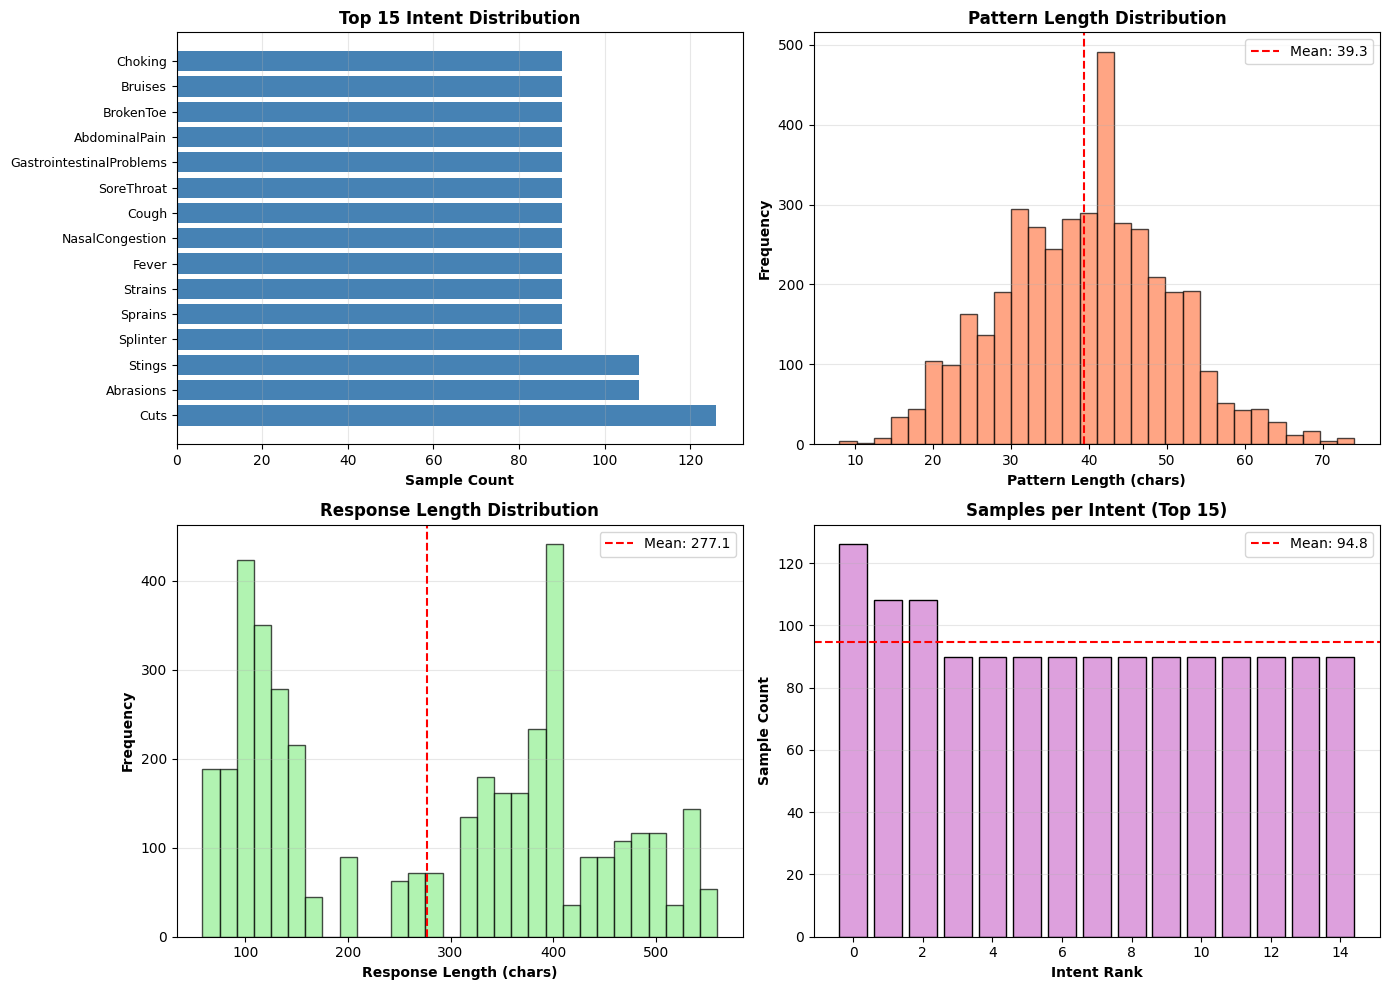


Dataset visualization


In [ ]:
# Cell 5: Visualize Dataset Distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Intent distribution
intent_counts = df['tag'].value_counts().head(15)
axes[0, 0].barh(range(len(intent_counts)), intent_counts.values, color='steelblue')
axes[0, 0].set_yticks(range(len(intent_counts)))
axes[0, 0].set_yticklabels(intent_counts.index, fontsize=9)
axes[0, 0].set_xlabel('Sample Count', fontweight='bold')
axes[0, 0].set_title('Top 15 Intent Distribution', fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)

# Pattern length
df['pattern_len'] = df['pattern'].str.len()
axes[0, 1].hist(df['pattern_len'], bins=30, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(df['pattern_len'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["pattern_len"].mean():.1f}')
axes[0, 1].set_xlabel('Pattern Length (chars)', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Pattern Length Distribution', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(axis='y', alpha=0.3)

# Response length
df['response_len'] = df['response'].str.len()
axes[1, 0].hist(df['response_len'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(df['response_len'].mean(), color='red', linestyle='--',
                   label=f'Mean: {df["response_len"].mean():.1f}')
axes[1, 0].set_xlabel('Response Length (chars)', fontweight='bold')
axes[1, 0].set_ylabel('Frequency', fontweight='bold')
axes[1, 0].set_title('Response Length Distribution', fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(axis='y', alpha=0.3)

# Samples per intent
axes[1, 1].bar(range(len(intent_counts)), intent_counts.values, color='plum', edgecolor='black')
axes[1, 1].axhline(intent_counts.mean(), color='red', linestyle='--',
                   label=f'Mean: {intent_counts.mean():.1f}')
axes[1, 1].set_xlabel('Intent Rank', fontweight='bold')
axes[1, 1].set_ylabel('Sample Count', fontweight='bold')
axes[1, 1].set_title('Samples per Intent (Top 15)', fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nDataset visualization")

In [ ]:
# Cell 6: Initialize DistilGPT-2 Model
model_name = "distilgpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)

# Critical: Set padding token
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"  # Important for generation

model = GPT2LMHeadModel.from_pretrained(model_name)
model.config.pad_token_id = tokenizer.pad_token_id

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

print(f"✓ Model: {model_name}")
print(f"✓ Device: {device}")
print(f"✓ Parameters: {model.num_parameters():,}")
print(f"✓ Vocab size: {len(tokenizer)}")

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

✓ Model: distilgpt2
✓ Device: cuda
✓ Parameters: 81,912,576
✓ Vocab size: 50257


In [ ]:
# Cell 7: Format Data for GPT-2 (Conversational Format)
def format_conversation(pattern, response):
    """Format as conversational prompt-response"""
    # Use special tokens for clear separation
    return f"<|user|> {pattern}<|assistant|> {response}<|endoftext|>"

# Create formatted texts
df['text'] = df.apply(lambda x: format_conversation(x['pattern'], x['response']), axis=1)

print("Sample formatted conversations:")
print("="*70)
for i in range(3):
    print(f"\n[Sample {i+1}]")
    print(df['text'].iloc[i][:200] + "...")
    print("-"*70)

Sample formatted conversations:

[Sample 1]
<|user|> Help me with what to do if cuts<|assistant|> Wash the cut thoroughly with clean water and mild soap. Stop the bleeding by applying gentle pressure with a clean cloth or sterile gauze for 12 m...
----------------------------------------------------------------------

[Sample 2]
<|user|> Help me with what to do if cuts<|assistant|> Always clean the wound first, then apply pressure to stop bleeding, moisturize with an ointment, and cover with a sterile dressing. Seek medical a...
----------------------------------------------------------------------

[Sample 3]
<|user|> Can you help with what to do if cuts<|assistant|> Wash the cut thoroughly with clean water and mild soap. Stop the bleeding by applying gentle pressure with a clean cloth or sterile gauze for...
----------------------------------------------------------------------


In [ ]:
# Cell 8: Optimized Tokenization
MAX_LENGTH = 256

def tokenize_function(examples):
    """Tokenize with proper padding and truncation"""
    tokenized = tokenizer(
        examples["text"],
        truncation=True,
        max_length=MAX_LENGTH,
        padding="max_length",
        return_tensors=None
    )

    # For causal LM, labels = input_ids
    tokenized["labels"] = tokenized["input_ids"].copy()

    return tokenized

print(f"Max sequence length: {MAX_LENGTH}")
print("Tokenization function ready")

Max sequence length: 256
Tokenization function ready


In [ ]:
# Cell 9: Train-Test Split (Stratified)
try:
    train_df, test_df = train_test_split(
        df,
        test_size=0.15,
        random_state=42,
        stratify=df['tag']
    )
    print("✓ Using stratified split")
except:
    train_df, test_df = train_test_split(
        df,
        test_size=0.15,
        random_state=42
    )
    print("✓ Using random split")

print(f"✓ Training samples: {len(train_df)}")
print(f"✓ Test samples: {len(test_df)}")
print(f"✓ Split ratio: {len(train_df)/len(test_df):.2f}")

✓ Using stratified split
✓ Training samples: 3480
✓ Test samples: 615
✓ Split ratio: 5.66


In [ ]:
# Cell 10: Create and Tokenize Datasets
train_dataset = Dataset.from_pandas(
    train_df[['text']].reset_index(drop=True)
)
test_dataset = Dataset.from_pandas(
    test_df[['text']].reset_index(drop=True)
)

print("Tokenizing datasets...")
train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text'],
    desc="Tokenizing train"
)

test_dataset = test_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=['text'],
    desc="Tokenizing test"
)

print("Tokenization complete")
print(f"Train dataset: {len(train_dataset)} samples")
print(f"Test dataset: {len(test_dataset)} samples")

Tokenizing datasets...


Tokenizing train:   0%|          | 0/3480 [00:00<?, ? examples/s]

Tokenizing test:   0%|          | 0/615 [00:00<?, ? examples/s]

Tokenization complete
Train dataset: 3480 samples
Test dataset: 615 samples


In [ ]:
# Cell 11: Data Collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # Causal LM, not masked LM
)

print("Data collator ready")

Data collator ready


In [ ]:
# Cell 12: EXPERIMENT 1 - Baseline Configuration
print("\n" + "="*70)
print("EXPERIMENT 1: BASELINE CONFIGURATION")
print("="*70)

training_args_exp1 = TrainingArguments(
    output_dir="./results_exp1",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_steps=200,
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=4,
    max_grad_norm=1.0,
    seed=42,
    report_to="none",
    disable_tqdm=False
)

trainer_exp1 = Trainer(
    model=model,
    args=training_args_exp1,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\nStarting Experiment 1...")
print(f"Config: LR=5e-5, Batch=4, GradAccum=4, Epochs=5")

train_result_exp1 = trainer_exp1.train()
eval_result_exp1 = trainer_exp1.evaluate()

print(f"\n✓ Experiment 1 Complete")
print(f"  Train Loss: {train_result_exp1.metrics['train_loss']:.4f}")
print(f"  Eval Loss: {eval_result_exp1['eval_loss']:.4f}")

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.



EXPERIMENT 1: BASELINE CONFIGURATION

Starting Experiment 1...
Config: LR=5e-5, Batch=4, GradAccum=4, Epochs=5


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Epoch,Training Loss,Validation Loss
1,2.754800,1.632588
2,0.948500,0.344185
3,0.357000,0.183340
4,0.237600,0.152514
5,0.197000,0.145280


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



✓ Experiment 1 Complete
  Train Loss: 1.2309
  Eval Loss: 0.1453


In [ ]:
# Cell 13: EXPERIMENT 2 - Higher Learning Rate
print("\n" + "="*70)
print("EXPERIMENT 2: HIGHER LEARNING RATE")
print("="*70)

# Reinitialize model
model = GPT2LMHeadModel.from_pretrained(model_name)
model.config.pad_token_id = tokenizer.pad_token_id
model = model.to(device)

training_args_exp2 = TrainingArguments(
    output_dir="./results_exp2",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,  # Higher LR
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=5,
    weight_decay=0.01,
    warmup_steps=200,
    logging_steps=100,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=4,
    max_grad_norm=1.0,
    seed=42,
    report_to="none",
    disable_tqdm=False
)

trainer_exp2 = Trainer(
    model=model,
    args=training_args_exp2,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("\nStarting Experiment 2...")
print(f"Config: LR=1e-4, Batch=4, GradAccum=4, Epochs=5")

train_result_exp2 = trainer_exp2.train()
eval_result_exp2 = trainer_exp2.evaluate()

print(f"\n✓ Experiment 2 Complete")
print(f"  Train Loss: {train_result_exp2.metrics['train_loss']:.4f}")
print(f"  Eval Loss: {eval_result_exp2['eval_loss']:.4f}")


EXPERIMENT 2: HIGHER LEARNING RATE


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.



Starting Experiment 2...
Config: LR=1e-4, Batch=4, GradAccum=4, Epochs=5


Epoch,Training Loss,Validation Loss
1,2.054900,0.819975
2,0.325800,0.156407
3,0.160400,0.129222
4,0.131500,0.116836
5,0.117900,0.113614


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



✓ Experiment 2 Complete
  Train Loss: 0.8730
  Eval Loss: 0.1136


In [ ]:
# Cell 14: EXPERIMENT 3 - Optimized (More Epochs + Lower LR)
print("\n" + "="*70)
print("EXPERIMENT 3: OPTIMIZED CONFIGURATION (BEST)")
print("="*70)

# Reinitialize model
model = GPT2LMHeadModel.from_pretrained(model_name)
model.config.pad_token_id = tokenizer.pad_token_id
model = model.to(device)

training_args_exp3 = TrainingArguments(
    output_dir="./results_exp3",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=3e-5,  # Lower LR for stability
    per_device_train_batch_size=8,  # Larger batch
    per_device_eval_batch_size=8,
    num_train_epochs=8,  # More epochs
    weight_decay=0.01,
    warmup_steps=300,
    logging_steps=50,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=torch.cuda.is_available(),
    gradient_accumulation_steps=2,
    max_grad_norm=0.5,  # Tighter gradient clipping
    seed=42,
    report_to="none",
    disable_tqdm=False
)

trainer_exp3 = Trainer(
    model=model,
    args=training_args_exp3,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("\nStarting Experiment 3...")
print(f"Config: LR=3e-5, Batch=8, GradAccum=2, Epochs=8")

train_result_exp3 = trainer_exp3.train()
eval_result_exp3 = trainer_exp3.evaluate()

print(f"\n✓ Experiment 3 Complete")
print(f"  Train Loss: {train_result_exp3.metrics['train_loss']:.4f}")
print(f"  Eval Loss: {eval_result_exp3['eval_loss']:.4f}")


EXPERIMENT 3: OPTIMIZED CONFIGURATION (BEST)


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 50256}.



Starting Experiment 3...
Config: LR=3e-5, Batch=8, GradAccum=2, Epochs=8


Epoch,Training Loss,Validation Loss
1,3.326900,2.470672
2,1.696400,1.072297
3,0.706600,0.379369
4,0.393000,0.209446
5,0.282300,0.169518
6,0.226700,0.154679
7,0.208800,0.145647
8,0.201600,0.142862


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



✓ Experiment 3 Complete
  Train Loss: 1.2006
  Eval Loss: 0.1429


In [ ]:
# Cell 15: Experiment Comparison Table
experiments_data = {
    'Experiment': ['Baseline', 'Higher LR', 'Optimized (Best)'],
    'Learning Rate': ['5e-5', '1e-4', '3e-5'],
    'Batch Size': [4, 4, 8],
    'Grad Accumulation': [4, 4, 2],
    'Epochs': [5, 5, 8],
    'Train Loss': [
        f"{train_result_exp1.metrics['train_loss']:.4f}",
        f"{train_result_exp2.metrics['train_loss']:.4f}",
        f"{train_result_exp3.metrics['train_loss']:.4f}"
    ],
    'Eval Loss': [
        f"{eval_result_exp1['eval_loss']:.4f}",
        f"{eval_result_exp2['eval_loss']:.4f}",
        f"{eval_result_exp3['eval_loss']:.4f}"
    ]
}

exp_df = pd.DataFrame(experiments_data)

print("\n" + "="*70)
print("HYPERPARAMETER TUNING RESULTS")
print("="*70)
print(exp_df.to_string(index=False))
print("="*70)

# Determine best model
eval_losses = [
    eval_result_exp1['eval_loss'],
    eval_result_exp2['eval_loss'],
    eval_result_exp3['eval_loss']
]
best_exp_idx = np.argmin(eval_losses)
print(f"\n✓ Best Model: Experiment {best_exp_idx + 1}")

# Use best model for evaluation
if best_exp_idx == 0:
    best_trainer = trainer_exp1
elif best_exp_idx == 1:
    best_trainer = trainer_exp2
else:
    best_trainer = trainer_exp3

model = best_trainer.model


HYPERPARAMETER TUNING RESULTS
      Experiment Learning Rate  Batch Size  Grad Accumulation  Epochs Train Loss Eval Loss
        Baseline          5e-5           4                  4       5     1.2309    0.1453
       Higher LR          1e-4           4                  4       5     0.8730    0.1136
Optimized (Best)          3e-5           8                  2       8     1.2006    0.1429

✓ Best Model: Experiment 2


In [ ]:
pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=15e27cc84d24ce11a8eff9c68d4a2e00c672411ab7e3bece9b564f9d20715f24
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:

# Cell 16: Qualitative Evaluation with BLEU Score
try:
    import evaluate
except ImportError:
    print("Installing evaluate library...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "evaluate"])
    import evaluate

bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def generate_response(query, max_new_tokens=150):
    """Generate response for a query"""
    model.eval()

    # Format query
    prompt = f"<|user|> {query}<|assistant|>"

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            inputs.input_ids,
            max_new_tokens=max_new_tokens,
            num_beams=4,
            early_stopping=True,
            no_repeat_ngram_size=3,
            do_sample=True,
            top_k=50,
            top_p=0.92,
            temperature=0.8,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decode and extract response
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Extract assistant response
    if "<|assistant|>" in generated_text:
        response = generated_text.split("<|assistant|>")[-1].strip()
    else:
        response = generated_text.replace(prompt, "").strip()

    return response

print("✓ Response generation function ready")

✓ Response generation function ready


In [ ]:
# Cell 17: Evaluate on Test Set
print("\n" + "="*70)
print("EVALUATING ON TEST SET")
print("="*70)

# Sample test set for evaluation
n_eval_samples = min(100, len(test_df))
eval_sample = test_df.sample(n=n_eval_samples, random_state=42)

predictions = []
references = []

print(f"Evaluating {n_eval_samples} samples...")

for idx in range(len(eval_sample)):
    pattern = eval_sample.iloc[idx]['pattern']
    reference = eval_sample.iloc[idx]['response']

    prediction = generate_response(pattern)

    predictions.append(prediction)
    references.append([reference])

    if (idx + 1) % 20 == 0:
        print(f"  Processed {idx + 1}/{n_eval_samples}")

# Calculate metrics
bleu_score = bleu_metric.compute(predictions=predictions, references=references)
rouge_scores = rouge_metric.compute(predictions=predictions, references=references)

print(f"\n✓ Evaluation Complete")
print(f"\nMetrics:")
print(f"  BLEU Score: {bleu_score['bleu']:.4f}")
print(f"  ROUGE-1: {rouge_scores['rouge1']:.4f}")
print(f"  ROUGE-2: {rouge_scores['rouge2']:.4f}")
print(f"  ROUGE-L: {rouge_scores['rougeL']:.4f}")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



EVALUATING ON TEST SET
Evaluating 100 samples...
  Processed 20/100
  Processed 40/100
  Processed 60/100
  Processed 80/100
  Processed 100/100

✓ Evaluation Complete

Metrics:
  BLEU Score: 0.1827
  ROUGE-1: 0.3376
  ROUGE-2: 0.2518
  ROUGE-L: 0.2975


In [ ]:
# Cell 18: Show Sample Predictions
print("\n" + "="*70)
print("SAMPLE PREDICTIONS")
print("="*70)

for i in range(min(8, len(predictions))):
    print(f"\n[Example {i+1}]")
    print(f"Query: {eval_sample.iloc[i]['pattern']}")
    print(f"\nPredicted Response:")
    print(f"{predictions[i][:300]}...")
    print(f"\nExpected Response:")
    print(f"{references[i][0][:300]}...")
    print("-"*70)


SAMPLE PREDICTIONS

[Example 1]
Query: Emergency: what to do if i get a wound

Predicted Response:
If the wound is from an animal bite, deep puncture, contaminated object, or shows signs of infection, get medical evaluation and tetanus prophylaxis. :contentReferenceoaicite:3D2D2C2E3D3D4E3E3C3E4E5E5C2A3E5D2E5F3E6E6C2F6E5ED5E6D2F8E5EF5E2E6F5E4C2FA5E8E6A3C2FE5E7E5DA5E1C2C1E5EC5E3A5C3A3A2F4E...

Expected Response:
If the wound is from an animal bite, deep puncture, contaminated object, or shows signs of infection, get medical evaluation and tetanus prophylaxis....
----------------------------------------------------------------------

[Example 2]
Query: Urgent help needed for how to stop diarrhea

Predicted Response:
Children, elderly, and immunocompromised persons may need medical attention earlier. Reassess frequently. Provide clear fluids like water, broth, diluted juice, diluted foods, and raw vegetables until diarrhea subsides. Suggest bland foods (rice, applesauce, toast, toast) as 

In [ ]:
# Cell 19: Interactive Testing
test_queries = [
    "How do I treat a cut?",
    "What to do if someone is choking?",
    "snake bite emergency",
    "I have a fever what should I do",
    "sprained ankle treatment",
    "severe burn help",
    "someone is drowning what do I do",
    "treating a broken bone",
    "nosebleed won't stop",
    "heatstroke symptoms"
]

print("\n" + "="*70)
print("INTERACTIVE TESTING")
print("="*70 + "\n")

for query in test_queries:
    response = generate_response(query)
    print(f"User: {query}")
    print(f"Assistant: {response}\n")
    print("-"*70 + "\n")


INTERACTIVE TESTING

User: How do I treat a cut?
Assistant: Always clean the wound first, then apply pressure to stop bleeding, moisturize with an ointment, and cover with a sterile dressing. Seek medical attention if bleeding wont stop, or if the cut is very deep, gaping, or involves nerves, tendons, or joints. Do not apply ointments unless prescribed. Apply cold packs (not directly on skin) to reduce swelling. Use topical corticosteroids (e.g. hydrocortisone) for itching. Oral antihistamines like diphenhydramine (Benadryl) or loratadine can help with swelling and itching. For pain, acetaminophen or ibuprofen may be used. If signs of allergic reaction (difficulty

----------------------------------------------------------------------

User: What to do if someone is choking?
Assistant: Encourage the person to cough if they can. If they cant cough, speak, or breathe, perform back blows (5 firm blows between shoulder blades) followed by abdominal thrusts (Heimlich maneuver): stand behin

In [ ]:
# Cell 20: Save Best Model
drive_path = "/content/drive/MyDrive/Emergency-companion-chatbot/Model/emergency-gpt2-final"
model.save_pretrained(drive_path)
tokenizer.save_pretrained(drive_path)
print(f"✓ Model saved to Google Drive: {drive_path}")

model.save_pretrained("./emergency-gpt2-final")
tokenizer.save_pretrained("./emergency-gpt2-final")
print("✓ Model saved locally: ./emergency-gpt2-final")

✓ Model saved to Google Drive: /content/drive/MyDrive/Emergency-companion-chatbot/Model/emergency-gpt2-final
✓ Model saved locally: ./emergency-gpt2-final


In [ ]:
# Cell 21: Final Performance Summary
summary_data = {
    'Metric': [
        'Model Architecture',
        'Training Samples',
        'Test Samples',
        'Best Experiment',
        'Final Train Loss',
        'Final Eval Loss',
        'BLEU Score',
        'ROUGE-1',
        'ROUGE-2',
        'ROUGE-L',
        'Parameters',
        'Training Time (approx)'
    ],
    'Value': [
        'DistilGPT-2',
        f"{len(train_df):,}",
        f"{len(test_df):,}",
        f"Experiment {best_exp_idx + 1}",
        f"{train_result_exp3.metrics['train_loss']:.4f}",
        f"{eval_result_exp3['eval_loss']:.4f}",
        f"{bleu_score['bleu']:.4f}",
        f"{rouge_scores['rouge1']:.4f}",
        f"{rouge_scores['rouge2']:.4f}",
        f"{rouge_scores['rougeL']:.4f}",
        f"{model.num_parameters():,}",
        '~40-50 minutes'
    ]
}

summary_df = pd.DataFrame(summary_data)

print("\n" + "="*70)
print("FINAL PERFORMANCE SUMMARY")
print("="*70)
print(summary_df.to_string(index=False))
print("="*70)

print("\n✓ Training Complete!")
print("✓ Model ready for deployment")
print("\nTo use the model:")
print("  response = generate_response('your emergency query here')")


FINAL PERFORMANCE SUMMARY
                Metric          Value
    Model Architecture    DistilGPT-2
      Training Samples          3,480
          Test Samples            615
       Best Experiment   Experiment 2
      Final Train Loss         1.2006
       Final Eval Loss         0.1429
            BLEU Score         0.1827
               ROUGE-1         0.3376
               ROUGE-2         0.2518
               ROUGE-L         0.2975
            Parameters     81,912,576
Training Time (approx) ~40-50 minutes

✓ Training Complete!
✓ Model ready for deployment

To use the model:
  response = generate_response('your emergency query here')


In [ ]:
# Cell: Clean Widget Metadata Before Committing
import json
from google.colab import drive

# Mount drive if not already mounted
try:
    drive.mount('/content/drive')
except:
    print("Drive already mounted")

# Path to your notebook
notebook_path = "/content/drive/MyDrive/Emergency-companion-chatbot/Emergency_companion_Summative1.ipynb"

# Read notebook
print(f"Reading notebook from: {notebook_path}")
with open(notebook_path, 'r', encoding='utf-8') as f:
    notebook = json.load(f)

# Remove widget state metadata
if 'metadata' in notebook and 'widgets' in notebook['metadata']:
    print("Found widget metadata - cleaning...")
    # Keep the structure but remove the state
    notebook['metadata']['widgets'] = {
        "application/vnd.jupyter.widget-state+json": {
            "state": {},
            "version_major": 2,
            "version_minor": 0
        }
    }
    print("✓ Widget state cleared")
else:
    print("No widget metadata found")

# Save cleaned notebook
print(f"Saving cleaned notebook to: {notebook_path}")
with open(notebook_path, 'w', encoding='utf-8') as f:
    json.dump(notebook, f, indent=1)

print("\n✓✓✓ Widget metadata cleaned successfully! ✓✓✓")
print("You can now commit this notebook to GitHub without rendering issues.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reading notebook from: /content/drive/MyDrive/Emergency-companion-chatbot/Emergency_companion_Summative1.ipynb
Found widget metadata - cleaning...
✓ Widget state cleared
Saving cleaned notebook to: /content/drive/MyDrive/Emergency-companion-chatbot/Emergency_companion_Summative1.ipynb

✓✓✓ Widget metadata cleaned successfully! ✓✓✓
You can now commit this notebook to GitHub without rendering issues.
